In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as pyplot
import imutils

import tensorflow as tf
import keras.layers as layers
import keras.models as models
import keras.optimizers as optimizers

import keras

from keras import backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout
from keras.models import Model
from keras.layers.merge import concatenate

In [3]:
def image_generator(image_numbers,batch_size=8):
    i = 0
    while True:
        batch_x = []
        
        batch_y = {'item': [],'item_name': [], 'item_price': [],'total': []}
        
        batch_numbers = np.random.choice(image_numbers, batch_size)
        
        for i in batch_numbers:
            img = cv2.cvtColor(cv2.imread('html-render/augmented/' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
            m_item = cv2.cvtColor(cv2.imread('html-render/augmented/' + str(i) + '_item.png'), cv2.COLOR_BGRA2GRAY)
            m_item_name = cv2.cvtColor(cv2.imread('html-render/augmented/' + str(i) + '_item-name.png'), cv2.COLOR_BGRA2GRAY)
            m_item_price = cv2.cvtColor(cv2.imread('html-render/augmented/' + str(i) + '_item-price.png'), cv2.COLOR_BGRA2GRAY)
            m_total = cv2.cvtColor(cv2.imread('html-render/augmented/' + str(i) + '_total.png'), cv2.COLOR_BGRA2GRAY)
            
            batch_x.append(img / 255.0)
            batch_y['item'].append(m_item.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['item_name'].append(m_item_name.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['item_price'].append(m_item_price.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['total'].append(m_total.reshape((img.shape[0], img.shape[1], 1))/255.0)
            
        
        batch_x = np.array(batch_x)
        batch_y['item'] = np.array(batch_y['item'])
        batch_y['item_name'] = np.array(batch_y['item_name'])
        batch_y['item_price'] = np.array(batch_y['item_price'])
        batch_y['total'] = np.array(batch_y['total'])
        
        
        yield (batch_x, batch_y)


In [4]:
def real_image_generator(image_numbers,batch_size=16):
    i = 0
    while True:
        batch_x = []
        
        batch_y = {'item': [],'item_name': [], 'item_price': [],'total': []}
        
        batch_numbers = np.random.choice(image_numbers, batch_size)
        
        for i in batch_numbers:
            img = cv2.cvtColor(cv2.imread('augmented-item-segmentation-images/' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
            m_item = cv2.cvtColor(cv2.imread('augmented-item-segmentation-images/' + str(i) + '_item.png'), cv2.COLOR_BGRA2GRAY)
            m_item_name = cv2.cvtColor(cv2.imread('augmented-item-segmentation-images/' + str(i) + '_item-name.png'), cv2.COLOR_BGRA2GRAY)
            m_item_price = cv2.cvtColor(cv2.imread('augmented-item-segmentation-images/' + str(i) + '_item-price.png'), cv2.COLOR_BGRA2GRAY)
            m_total = cv2.cvtColor(cv2.imread('augmented-item-segmentation-images/' + str(i) + '_total.png'), cv2.COLOR_BGRA2GRAY)
            
            img = cv2.resize(img, (320, 864))
            m_item = cv2.resize(m_item, (320, 864))
            m_item_name = cv2.resize(m_item_name, (320, 864))
            m_item_price = cv2.resize(m_item_price, (320, 864))
            m_total = cv2.resize(m_total, (320, 864))
            
            batch_x.append(img / 255.0)
            batch_y['item'].append(m_item.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['item_name'].append(m_item_name.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['item_price'].append(m_item_price.reshape((img.shape[0], img.shape[1], 1))/255.0)
            batch_y['total'].append(m_total.reshape((img.shape[0], img.shape[1], 1))/255.0)
        
        batch_x = np.array(batch_x)
        batch_y['item'] = np.array(batch_y['item'])
        batch_y['item_name'] = np.array(batch_y['item_name'])
        batch_y['item_price'] = np.array(batch_y['item_price'])
        batch_y['total'] = np.array(batch_y['total'])
        
        
        yield (batch_x, batch_y)


In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
inp = models.Input((None, None, 3))
activation = 'elu'
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(inp)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c1 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c2 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c3 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c4 = l
l = layers.MaxPool2D()(l)

l = layers.Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
l = layers.Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(l)
c5 = l
l = layers.MaxPool2D()(l)

item_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
item_l = concatenate([item_l, c5])
item_l = layers.Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_l = layers.Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)

item_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_l = concatenate([item_l, c4])
item_l = layers.Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_l = layers.Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)

item_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_l = concatenate([item_l, c3])
item_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)

###


item_item_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_item_l = concatenate([item_item_l, c2])
item_item_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_item_l)
item_item_l_c2 = item_item_l

item_item_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_item_l)
item_item_l = concatenate([item_item_l, c1])
item_item_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_item_l)
item_item_l_c1 = item_item_l

###

item_name_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_name_l = concatenate([item_name_l, c2, item_item_l_c2])
item_name_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_name_l)

item_name_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_name_l)
item_name_l = concatenate([item_name_l, c1, item_item_l_c1])
item_name_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_name_l)

###

item_price_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_l)
item_price_l = concatenate([item_price_l, c2, item_item_l_c2])
item_price_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_price_l)

item_price_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(item_price_l)
item_price_l = concatenate([item_price_l, c1, item_item_l_c1])
item_price_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(item_price_l)

###

total_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(l)
total_l = concatenate([total_l, c5])
total_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)

total_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)
total_l = concatenate([total_l, c4])
total_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)

total_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)
total_l = concatenate([total_l, c3])
total_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)

total_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)
total_l = concatenate([total_l, c2])
total_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)

total_l = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)
total_l = concatenate([total_l, c1])
total_l = layers.Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same')(total_l)


item = layers.Conv2D(1, (1, 1), name='item', activation='sigmoid', kernel_initializer='he_normal', padding='same')(item_item_l)
item_name = layers.Conv2D(1, (1, 1), name='item_name', activation='sigmoid', kernel_initializer='he_normal', padding='same')(item_name_l)
item_price = layers.Conv2D(1, (1, 1), name='item_price', activation='sigmoid', kernel_initializer='he_normal', padding='same')(item_price_l)
total = layers.Conv2D(1, (1, 1), name='total', activation='sigmoid', kernel_initializer='he_normal', padding='same')(total_l)

model = models.Model(inp, [item, item_name, item_price, total])

In [7]:
model.compile(optimizer=optimizers.Adam(0.00001), 
              loss={
                'item': 'binary_crossentropy',
                'item_name': 'binary_crossentropy',
                'item_price': 'binary_crossentropy',
                'total': 'binary_crossentropy'
              }, 
              metrics=[
                    mean_iou
              ])

In [8]:
#model.summary()
#model = keras.models.load_model('bill-segmentation-model-0.9546.h5', custom_objects={'mean_iou': mean_iou})

In [9]:
p = np.random.permutation(np.arange(1, 1000))

In [10]:
model.fit_generator(
          image_generator(p[:900]),
          validation_data=image_generator(p[900:]),
          validation_steps=5,
          steps_per_epoch=100,
          epochs=10000,
          callbacks=[
              #keras.callbacks.EarlyStopping(monitor='val_mean_iou', patience=30, verbose=False, mode='max', baseline=None, restore_best_weights=True)
              keras.callbacks.ModelCheckpoint('models/items-segmentation-model-lr0.0001-{epoch:08d}.h5', save_weights_only=False, period=10)
          ])

Epoch 1/10000
100/100 [==============================] - 41s 406ms/step - loss: 4.1532 - item_loss: 1.9284 - item_name_loss: 0.5296 - item_price_loss: 0.8285 - total_loss: 0.8668 - item_mean_iou: 0.1386 - item_name_mean_iou: 0.4524 - item_price_mean_iou: 0.3951 - total_mean_iou: 0.3767 - val_loss: 3.7364 - val_item_loss: 1.7221 - val_item_name_loss: 0.4723 - val_item_price_loss: 0.7716 - val_total_loss: 0.7704 - val_item_mean_iou: 0.1532 - val_item_name_mean_iou: 0.4645 - val_item_price_mean_iou: 0.4102 - val_total_mean_iou: 0.3952
Epoch 2/10000
100/100 [==============================] - 28s 276ms/step - loss: 3.4249 - item_loss: 1.5783 - item_name_loss: 0.4271 - item_price_loss: 0.7278 - total_loss: 0.6917 - item_mean_iou: 0.1672 - item_name_mean_iou: 0.4695 - item_price_mean_iou: 0.4195 - total_mean_iou: 0.4081 - val_loss: 3.1084 - val_item_loss: 1.4222 - val_item_name_loss: 0.3891 - val_item_price_loss: 0.6869 - val_total_loss: 0.6102 - val_item_mean_iou: 0.1819 - val_item_name_mean

KeyboardInterrupt: 

In [ ]:
real_p = np.random.permutation(np.arange(1, 1001))

In [ ]:
model.fit_generator(
          real_image_generator(real_p[:900]),
          validation_data=real_image_generator(real_p[900:]),
          validation_steps=5,
          steps_per_epoch=100,
          epochs=10000,
          callbacks=[
              #keras.callbacks.EarlyStopping(monitor='val_mean_iou', patience=30, verbose=False, mode='max', baseline=None, restore_best_weights=True)
              keras.callbacks.ModelCheckpoint('models/items-segmentation-model-real-lr0.00001-{epoch:08d}.h5', save_weights_only=False, period=10)
          ])

Epoch 1/10000
100/100 [==============================] - 95s 954ms/step - loss: 0.0322 - item_loss: 0.0196 - item_name_loss: 0.0094 - item_price_loss: 0.0018 - total_loss: 0.0014 - item_mean_iou: 0.8784 - item_name_mean_iou: 0.9038 - item_price_mean_iou: 0.8881 - total_mean_iou: 0.9402 - val_loss: 0.0472 - val_item_loss: 0.0273 - val_item_name_loss: 0.0138 - val_item_price_loss: 0.0028 - val_total_loss: 0.0033 - val_item_mean_iou: 0.8869 - val_item_name_mean_iou: 0.9128 - val_item_price_mean_iou: 0.8973 - val_total_mean_iou: 0.9490
Epoch 2/10000
100/100 [==============================] - 66s 659ms/step - loss: 0.0329 - item_loss: 0.0200 - item_name_loss: 0.0096 - item_price_loss: 0.0018 - total_loss: 0.0015 - item_mean_iou: 0.8858 - item_name_mean_iou: 0.9118 - item_price_mean_iou: 0.8963 - total_mean_iou: 0.9485 - val_loss: 0.0429 - val_item_loss: 0.0254 - val_item_name_loss: 0.0125 - val_item_price_loss: 0.0026 - val_total_loss: 0.0024 - val_item_mean_iou: 0.8856 - val_item_name_mean

100/100 [==============================] - 66s 660ms/step - loss: 0.0324 - item_loss: 0.0197 - item_name_loss: 0.0095 - item_price_loss: 0.0018 - total_loss: 0.0014 - item_mean_iou: 0.8861 - item_name_mean_iou: 0.9121 - item_price_mean_iou: 0.8967 - total_mean_iou: 0.9488 - val_loss: 0.0632 - val_item_loss: 0.0357 - val_item_name_loss: 0.0221 - val_item_price_loss: 0.0031 - val_total_loss: 0.0023 - val_item_mean_iou: 0.8861 - val_item_name_mean_iou: 0.9121 - val_item_price_mean_iou: 0.8967 - val_total_mean_iou: 0.9488
Epoch 32/10000
100/100 [==============================] - 66s 661ms/step - loss: 0.0323 - item_loss: 0.0197 - item_name_loss: 0.0094 - item_price_loss: 0.0018 - total_loss: 0.0014 - item_mean_iou: 0.8860 - item_name_mean_iou: 0.9121 - item_price_mean_iou: 0.8967 - total_mean_iou: 0.9488 - val_loss: 0.0555 - val_item_loss: 0.0314 - val_item_name_loss: 0.0186 - val_item_price_loss: 0.0027 - val_total_loss: 0.0027 - val_item_mean_iou: 0.8861 - val_item_name_mean_iou: 0.9121 

In [36]:
model.save('items-segmentation-model-0.0045.h5')

In [11]:
#x_img_path = '/home/freefly19/Pictures/mac.png'
#x_img_path = '/home/freefly19/Pictures/mac2.png'
x_img_path = '1_warped.jpg'
#x_img_path = '/home/freefly19/projects/bill-digitalization/images/5.jpg'
#X = np.array([np.array(cv2.resize(cv2.cvtColor(cv2.imread('html-render/generated/1_origin.png'), cv2.COLOR_BGR2RGB), (320, 864))) / 255.0])
X = np.array([np.array(cv2.resize(cv2.cvtColor(cv2.imread(x_img_path), cv2.COLOR_BGR2RGB), (320, 864))) / 255.0])

In [12]:
preds = model.predict(X)

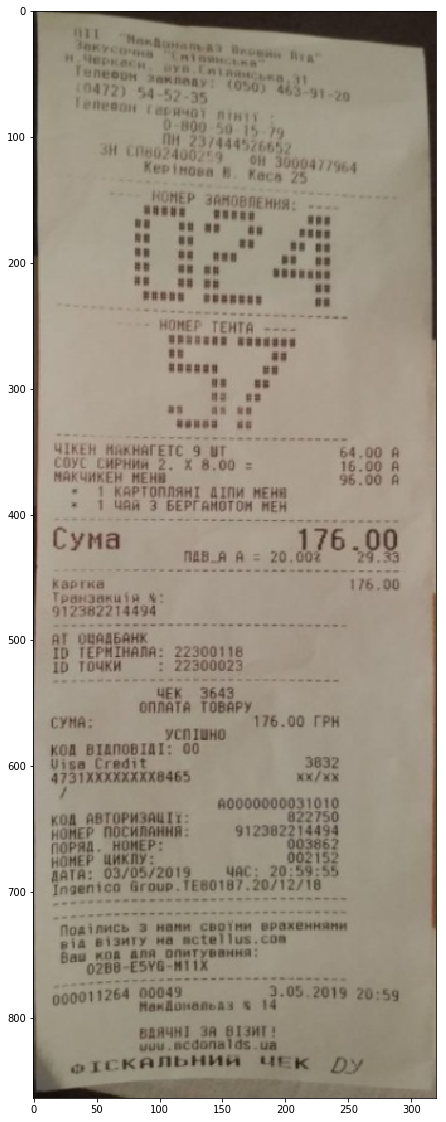

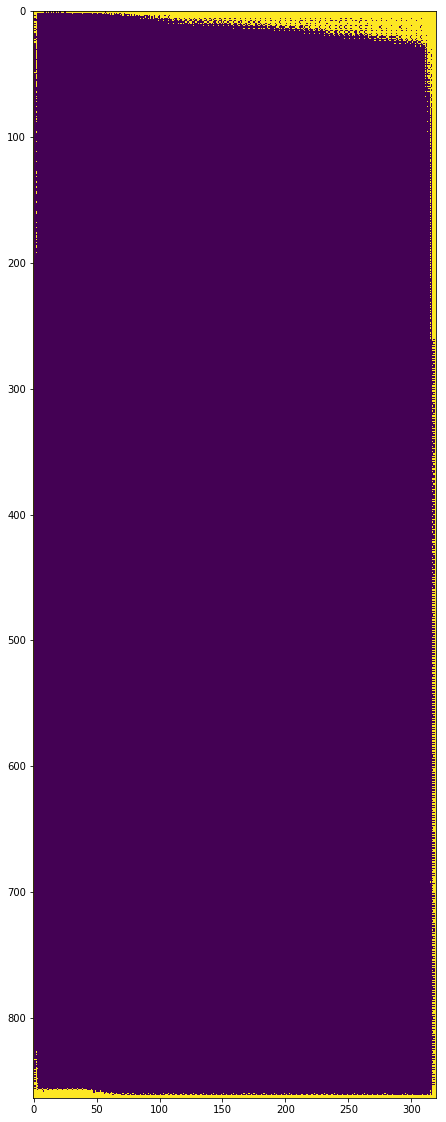

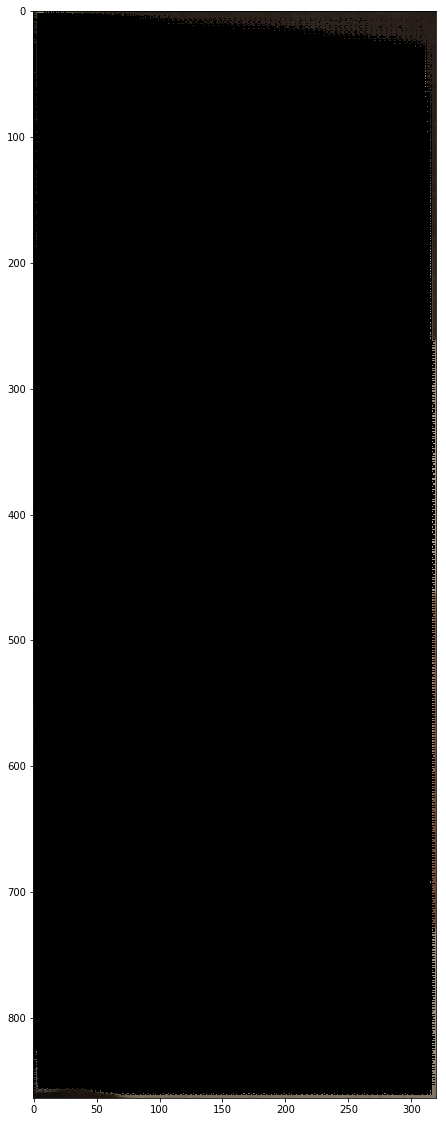

In [16]:
pred = np.where(preds[2][0] > 0.1, 1, 0)
pred = pred.reshape((pred.shape[0], pred.shape[1]))

pyplot.figure(figsize=(20, 20))
pyplot.imshow(X[0])

pyplot.figure(figsize=(20, 20))
pyplot.imshow(pred)

x_masked = X[0].copy()
x_masked[pred==0] = (0,0,0)
pyplot.figure(figsize=(20, 20))
pyplot.imshow(x_masked)